In [2]:
import numpy as np
import matplotlib.pyplot as pl

import matplotlib.style as mplstyle
import seaborn as sns

import sys
sys.path.insert(1, '../')
from src.core import intersect
from src.core.gaussian_beam_propagation import FocusedGaussianBeam
mplstyle.use('seaborn')
sns.set_style("darkgrid")

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.cubehelix_palette(100, start=.5, rot=-.75, reverse=True))

ModuleNotFoundError: No module named 'intersect'

In [ ]:
import os
cwd = os.getcwd()
foldir = ''
datadir = os.path.join(cwd, foldir) 

In [ ]:
print (datadir)

/Users/hannaharjonillo/Documents/gbp-mc/notebooks/


In [ ]:
def filename(code, num_photons, num_steps, scat_deg, g, trial):
    names = [f'ray', f'out', f'med', f'his', f'medprop']
    return names[code] + f'N{num_photons}s{num_steps}R{int(scat_deg)}g{int(g*10)}t{trial}.npy'

In [6]:
def load_id(scattering_degree, g, trials):
    subfoldir = '' # f'r{scattering_degree}'
    fullpath = os.path.join(datadir, subfoldir)
    rays = np.load(os.path.join(fullpath, f'rayR{int(scattering_degree)}g{int(g*10)}t{trial}.npy'))
#     rays = np.load('r2' + f'rayR{int(scattering_degree)}g{int(g*10)}t{trial}.npy')
    scattered_out = np.load(os.path.join(fullpath, f'outR{int(scattering_degree)}g{int(g*10)}t{trial}.npy'))
    scatterer_centers = np.load(os.path.join(fullpath, f'medR{int(scattering_degree)}g{int(g*10)}t{trial}.npy'))
    scatter_history = np.load(os.path.join(fullpath, f'hisR{int(scattering_degree)}g{int(g*10)}t{trial}.npy'))
    scat_props = np.load(os.path.join(fullpath, f'medpropR{int(scattering_degree)}g{int(g*10)}t{trial}.npy'))
    
    rays = np.concatenate(rays, axis=1)
    scattered_out = np.concatenate(scattered_out.reshape(10, 1000, 100), axis=0)
    scatter_history = np.concatenate(scatter_history.reshape(10, 1000, 100), axis=0)
    
    return rays, scattered_out, scatterer_centers, scatter_history, scat_props

In [7]:
def load_and_join_trials(code, num_trials, num_photons, num_steps, scattering_degree, g):
    subfoldir = '' # f'r{scattering_degree}'
    fullpath = os.path.join(datadir, subfoldir)
    file = filename(code, num_photons, num_steps, scattering_degree, g, trial=0)
    t0 = np.load(os.path.join(fullpath, file))
    arr = []

    for trial in range(num_trials):
        temp = np.load(os.path.join(fullpath, filename(code, num_photons, num_steps, scattering_degree, g, trial)))
#         if code == 0:
#             temp = temp.reshape(10, 3, temp.shape[-2], temp.shape[-1]//10)
#             temp = np.concatenate(temp, axis=1)
#         elif (code == 1) or (code == 3):
#             temp = temp.reshape(10, temp.shape[-2], temp.shape[-1]//10)
#             temp = np.concatenate(temp, axis=0)
        arr.append(temp)
#         arr[trial] = np.load(subfoldir + filename(code, scattering_degree, g, trial))
        
    return np.array(arr)

In [8]:
def rays_to_contour(rays, axial_range=21, resolution=201):
    num_steps = rays.shape[2]
    axial_planes = np.linspace(-axial_range, axial_range, resolution)
    intersections_per_plane = [[],[]]
    
    for p in range(len(axial_planes)):
        for step in range(num_steps-1):
            # check if rays intersect this plane at all
            plane = axial_planes[p]
            intersects_plane = (rays[2, :, step+1] > plane) & (rays[2, :, step] < plane)
            # calculate points of intersection for this plane
            intersections = intersect.ray_xyplane(plane, rays[:, intersects_plane, step], rays[:, intersects_plane, step+1])
            intersections_per_plane[0].extend(intersections[0])
            intersections_per_plane[1].extend(intersections[2])
            
    return intersections_per_plane, axial_planes

In [9]:
def plot_contour(intersections_per_plane, axial_planes):
    pl.figure()
    transverse_edges = axial_planes
    axial_edges = axial_planes
    trans_img_range = [axial_planes[0], axial_planes[-1]]
    axial_img_range = trans_img_range
    # change this later
    H_ave, transverse_edges, axial_edges = np.histogram2d(intersections_per_plane[0], intersections_per_plane[1],
                          bins=[transverse_edges, axial_edges])
    
    ub = (transverse_edges[:-1] + transverse_edges[1:])/2
    vb = (axial_edges[:-1] + axial_edges[1:])/2
    xv, zv = np.meshgrid(ub, vb)

    H_normed = H_ave.T/np.amax(H_ave)
#     levels = H_normed[:, H_normed.shape[0]//2]/(np.e**2)
    CS = pl.contourf(zv, xv, H_ave.T/np.amax(H_ave), N=100, cmap=pl.cm.viridis, origin='lower')
#     CS2 = pl.contour(CS, levels=levels, colors='#8C73A3', linewidths=0.1,
#                      origin='lower')
    pl.colorbar(CS)
#    pl.clabel(CS2, inline=True, fontsize=5)
    NA = 0.4
    N_photons = int(1E4)
    theo_beam = FocusedGaussianBeam(NA=NA)
    z = axial_planes
    x = axial_planes
    geometrical_shadow = theo_beam.beam_radius(z)
    pl.plot(z, geometrical_shadow, 'w', linewidth=0.5)
    pl.plot(z, -geometrical_shadow, 'w', linewidth=0.5)
    pl.plot(theo_beam.focal_tolerance * np.ones(shape=(x.shape)), x, 'r',
            linewidth=0.5)
    pl.plot(-theo_beam.focal_tolerance * np.ones(shape=(x.shape)), x, 'r',
            linewidth=0.5)
    pl.ylim(trans_img_range[0], trans_img_range[1])
    pl.xlim(axial_img_range[0], axial_img_range[1])
    pl.xlabel(r'z ($\mu$m)')
    pl.ylabel(r'x ($\mu$m)')
    pl.title('Unscattered photon distribution \n NA = %.1f, N = %d'
             % (NA, N_photons))
    pl.figure()

In [10]:
def linfoot(signal_expt, signal_theo):
    '''
    C: relative structural content
    F: fidelity
    Q: correlation quality
    '''
    # normalize
    sig_expt_sum = np.sum(signal_expt)
    sig_theo_sum = np.sum(signal_theo)
    if sig_expt_sum != 0:
        signal_expt /= sig_expt_sum
    if sig_theo_sum != 0:
        signal_theo /= sig_theo_sum
        
    print(np.sum(signal_expt), np.sum(signal_theo))
    
    C = np.mean(signal_expt**2) / np.mean(signal_theo**2)
    F = 1 - np.mean((signal_expt - signal_theo)**2)/np.mean(signal_theo**2)
    Q = np.mean(signal_expt*signal_theo) / np.mean(signal_theo**2)

    return C, F, Q

In [11]:
def plots1(X, Z, intensity, alpha, savefig=True):
#     extent = (X[0, 5], X[0, -5], Z[5, 0], Z[-5, 0])
    extent = (-30, 30, -15, 15)
    print(extent)
    # X for x axis, Z for y axis
    pl.figure()

    pl.contour(intensity, levels=np.logspace(-4,1, 20), cmap=pl.cm.gray, linewidths=0.5, extent=extent)
#     ax2.contour(intensity, levels=[np.amax(intensity)/np.e**2], cmap=pl.cm.gray, linewidths=1.0, extent=extent)
    pl.imshow(intensity, cmap=cmap, extent=extent)
    
    pl.tight_layout()
    
    if savefig is True:
        pl.savefig(f'{title}.png', dpi=300)

In [12]:
def plots2(X, Z, intensity, alpha):
#     extent = (X[0, 5], X[0, -5], Z[5, 0], Z[-5, 0])
    extent = (-30, 30, -15, 15)
    print(extent)
    # X for x axis, Z for y axis
    fig = pl.figure()

    ax1 = pl.subplot2grid((3, 5), (0, 0), colspan=4)
    ax2 = pl.subplot2grid((3, 5), (1, 0), colspan=4, rowspan=2)
    ax3 = pl.subplot2grid((3, 5), (1, 4), rowspan=2)

    ax1.plot(X[0], intensity[intensity.shape[0]//2, :])
    ax1.set_xlim(extent[0], extent[1])
    ax2.contour(intensity, levels=np.logspace(-4,1, 20), cmap=pl.cm.gray, linewidths=0.5, extent=extent)
#     ax2.contour(intensity, levels=[np.amax(intensity)/np.e**2], cmap=pl.cm.gray, linewidths=1.0, extent=extent)
    ax2.imshow(intensity, cmap=cmap, extent=extent)
    ax3.plot(intensity[:, intensity.shape[1]//2], Z[:, 0])
    ax3.set_ylim(extent[2], extent[3])
    
    pl.tight_layout()

In [13]:
def polyfit(x, y, degree):
    coeffs = np.polyfit(x, y, degree)

    # r-squared
    p = np.poly1d(coeffs)
    
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    r2 = ssreg / sstot
    
    return coeffs, p, r2

In [14]:
def fit_and_plot(x, y, degree, xlabel, ylabel, title, yerr=None, savefig=False, plot_num=1):
    coeffs, p, r2 = polyfit(x, y, degree=degree)
    print(coeffs, r2)

    xp = np.linspace(np.min(x),np.max(x),100)
    print(np.min(x), np.max(x))
    label_eq = f'R = {plot_num*2}: '
    for i in range(0, len(coeffs)):
        label_eq += f'{coeffs[i]:.2E}'
        if i < len(coeffs)-1:
            label_eq += f'$x^{len(coeffs)-1-i}$ + '
    label_eq += f'\n $R^2$ = {r2:.4f}'

    colors = ['', 'C0', 'C1', 'C2', 'C3']
    ax = pl.subplot()
#     ax.set_xscale("log", nonposx='clip')
#     ax.set_yscale("log", nonposy='clip')
    if yerr is not None:
        pl.errorbar(x, y, yerr=yerr, fmt='o', color=colors[plot_num])
    pl.plot(x, y, 'o', color=colors[plot_num])
    pl.plot(xp, p(xp), color=colors[plot_num], label=label_eq, alpha=0.7)
    pl.xlabel(xlabel)
    pl.ylabel(ylabel)
    pl.legend(loc='best')
    pl.title(title)
    
    if savefig is True:
        pl.savefig(f'{title}.png', dpi=300)

In [13]:
R = []
SCATOUT = []
SCATCENTERS = []
SCAT_HISTORY = []
SCAT_PROPS = []
STOP_STEP = []
START_STEP = []
FREE_PATHS = []
num_trials = 5
g = 0
num_photons = 30000
num_steps = 100
for scat_degree in range(0, 7, 2):
    if scat_degree == 0:
        g = 0
    else: 
        g = 0.2
    rays = load_and_join_trials(0, num_trials, num_photons, num_steps, scat_degree, g)
    scattered_out = load_and_join_trials(1, num_trials, num_photons, num_steps, scat_degree, g)
    scatterer_centers = load_and_join_trials(2, num_trials, num_photons, num_steps, scat_degree, g)
    scatter_history = load_and_join_trials(3, num_trials, num_photons, num_steps, scat_degree, g)
    scat_props = load_and_join_trials(4, num_trials, num_photons, num_steps, scat_degree, g)
    R.append(rays)
    print(rays.shape, scattered_out.shape, scatter_history.shape)
    SCATOUT.append(scattered_out)
    SCATCENTERS.append(scatterer_centers)
    SCAT_HISTORY.append(scatter_history)
    SCAT_PROPS.append(scat_props)
    
    stop_step = np.argmax(scattered_out, axis=2) # get step at which the photon is scattered out
    # stop_step = 1*np.ones(shape=ray_data2.shape[1], dtype=int)
    zero_stop_step = stop_step == 0 # zero stop step means it was out even at the first step
    stop_step[zero_stop_step] = rays.shape[2] - 1 # set at last step
    # stop_step

    start_step = np.argmax(scatter_history, axis=2) # get step at which photon gets scattered for the first time
    zero_start_step = start_step == 0 # zero start step means it never got scattered 
    start_step[zero_start_step] = rays.shape[2] - 1 # set at last step, actually meaning it never happened
    stop_step.shape
    
    START_STEP.append(start_step)
    STOP_STEP.append(stop_step)
    
    # free paths
    diffs = rays[:, :, :, 1:] - rays[:, :, :, :-1]
    dists = np.sqrt(diffs[:, 0]**2 + diffs[:, 1]**2 + diffs[:,2]**2)
#     print(dists)
    FREE_PATHS.append(dists)

(5, 3, 30000, 100) (5, 30000, 100) (5, 30000, 100)
(5, 3, 30000, 100) (5, 30000, 100) (5, 30000, 100)


/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in subtract


(5, 3, 30000, 100) (5, 30000, 100) (5, 30000, 100)
(5, 3, 30000, 100) (5, 30000, 100) (5, 30000, 100)


0
1
2
3


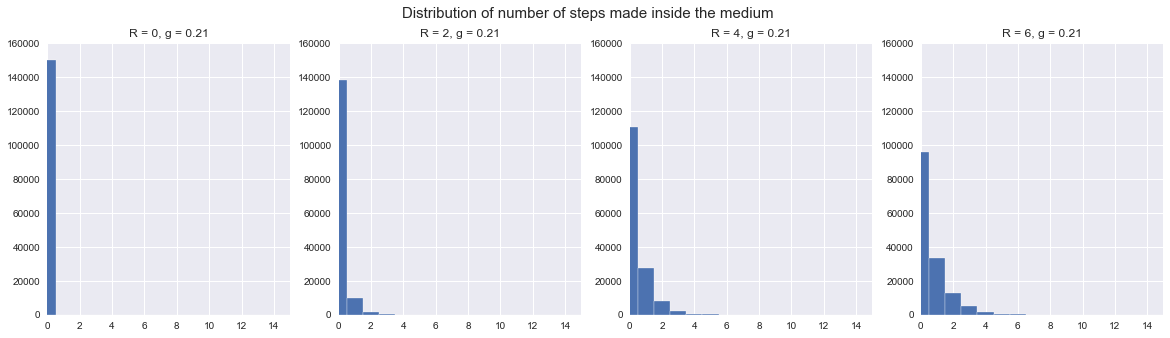

In [86]:
f, axarr = pl.subplots(1, len(R), figsize=(5*len(R),5))
bins = np.arange(0,100)
hist_numsteps = np.zeros(shape=(len(R), len(bins)-1))
for i in range(len(R)):
    print(i)
    hist, edges = np.histogram(np.ravel(STOP_STEP[i]-START_STEP[i]), bins=bins)
    hist_numsteps[i] = hist
    axarr[i].bar(edges[:-2], hist[:-1], width=1)
    axarr[i].set_title(f'R = {i*2}, g = 0.21')
    axarr[i].set_xlim(0, 15)
    axarr[i].set_ylim(0, 160000)
f.suptitle('Distribution of number of steps made inside the medium', fontsize=15)
# pl.show()
pl.savefig('isotropic-stepsinmedium.png', dpi=300)
# pl.show()

7
[1.38245e+05 9.81000e+03 1.60100e+03 2.91000e+02 4.40000e+01 7.00000e+00
 2.00000e+00]
[0 1 2 3 4 5 6]
[-0.79903353  4.90998395] 0.9930270217307479
0 6
10
[1.10741e+05 2.75070e+04 8.21600e+03 2.52900e+03 7.15000e+02 2.07000e+02
 5.40000e+01 1.90000e+01 1.00000e+01 2.00000e+00]
[0 1 2 3 4 5 6 7 8 9]
[-0.51815239  4.9600672 ] 0.997187013416626
0 9
12
[9.5865e+04 3.3252e+04 1.2849e+04 5.0510e+03 1.8200e+03 7.1500e+02
 2.7400e+02 9.8000e+01 4.5000e+01 2.0000e+01 4.0000e+00 5.0000e+00]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[-0.40739931  4.91689212] 0.994030114764099
0 11


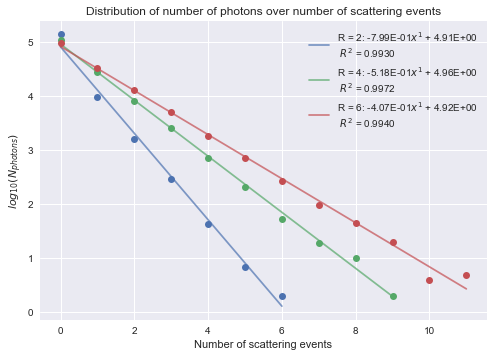

In [85]:
# pl.plot(bins[:-1], np.log(hist_numsteps[1]), '.')
for i in range(1,len(R)):
    stop_fit = np.argmax(hist_numsteps[i] == 0) 
    print(stop_fit)
    print(hist_numsteps[i, :stop_fit])
    print(bins[:stop_fit])
    fit_and_plot(bins[:stop_fit], np.log10(hist_numsteps[i, :stop_fit]), 1, 'Number of scattering events', r'$log_{10}(N_{photons})$', 'Distribution of number of photons over number of scattering events', savefig=True, plot_num=i)

In [87]:
transverse_intensities = []
axial_intensities = []
axial_intensities_std = []
hists = []
transverse_edges = []
axial_edges = []

h_ave = []
h_std = []

for scat_degree in range(len(R)): 
    rays = R[scat_degree]
    for trial in range(5):
#         print(rays[trial].shape)
        intersections_per_plane, axial_planes = rays_to_contour(rays[trial])
        intersections_per_plane = np.array(intersections_per_plane)
#         print(intersections_per_plane.shape)
        h, xedges, yedges = np.histogram2d(intersections_per_plane[0], intersections_per_plane[1], bins=[axial_planes, axial_planes])
        hists.append(h)
    histsarr = np.array(hists)
    h_ave.append(np.average(histsarr, axis=0))
    h_std.append(np.std(histsarr, axis=0))

#     print(h_ave[scat_degree].shape)
    transverse_intensities.append(h_ave[scat_degree][:, h_ave[scat_degree].shape[1]//2])
    axial_intensities.append(h_ave[scat_degree][h_ave[scat_degree].shape[1]//2, :])
    axial_intensities_std.append(h_std[scat_degree][h_std[scat_degree].shape[1]//2, :])
    hists.append(h)
    axial_edges.append(xedges)
    transverse_edges.append(yedges)


In [88]:
beam = FocusedGaussianBeam(NA=0.4, n=1.33, trunc_coeff=4)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


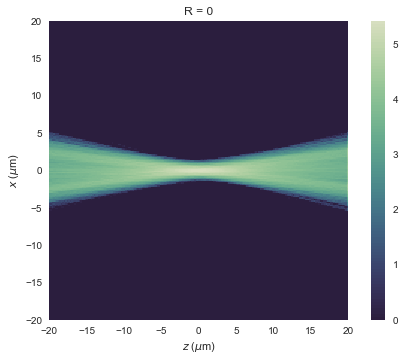

In [33]:
for scat_degree in range(len(R)):
    pl.figure()
    hist_logscale = np.log(h_ave[scat_degree])
    hist_logscale[np.isinf(hist_logscale)] = 0
    hist_logscale[np.isnan(hist_logscale)] = 0
    pl.imshow(hist_logscale, origin='lower', extent=(-20, 20, -20, 20), cmap=cmap, vmin=0)
    pl.colorbar()
    pl.title(f'R = {(scat_degree) * 2}')
    pl.xlabel(r'$z$ ($\mu$m)')
    pl.ylabel(r'$x$ ($\mu$m)')
    pl.savefig(f'intensitydist-R{scat_degree * 2}.png', dpi=300)

(-30, 30, -15, 15)
0.0 2158.4
(-30, 30, -15, 15)
0.0 3513.090909090909
(-30, 30, -15, 15)
0.0 4147.64705882353
(-30, 30, -15, 15)
0.0 4477.478260869565


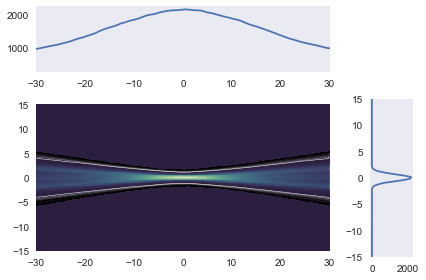

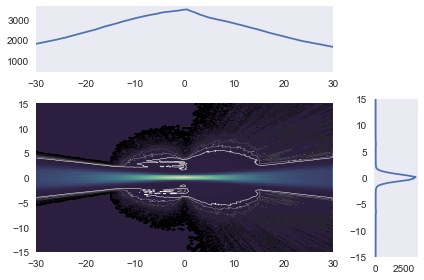

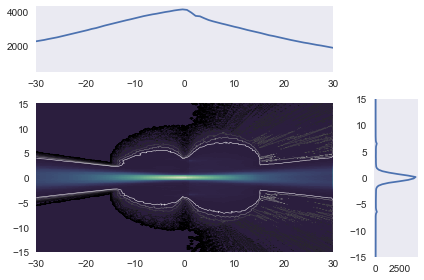

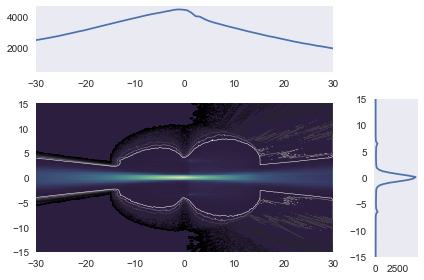

In [20]:
for scat_degree in range(len(R)):
    x = axial_edges[scat_degree]
    x = (x[:-1] + x[1:])/2
    z = transverse_edges[scat_degree]
    z = (z[:-1] + z[1:])/2
    v, u = beam.change_coords(x, z)
    X, Z = np.meshgrid(v, u)

    intensity = h_ave[scat_degree]
    plots1(X, Z, intensity, alpha=4, savefig=True)
    print(np.amin(intensity), np.amax(intensity))

In [16]:
beam = FocusedGaussianBeam(NA=0.4, n=1.33, z_f=0, trunc_coeff=4)
x = (transverse_edges[scat_degree][1:] + transverse_edges[scat_degree][1:])/2
x = np.linspace(x[0], x[-1], 100)
z = (axial_edges[scat_degree][1:] + axial_edges[scat_degree][:-1])/2
z = np.linspace(z[0], z[-1], 100)
# print(x)
X, Z = np.meshgrid(x, z)
# myfunc = np.vectorize(beam.intensity_3d)
# intensity = myfunc(np.abs(X), Z)

V, U, field = beam.debye_approx_field(np.abs(X), Z)
intensity = np.array(np.abs(field)**2, dtype=np.float64)
intensity = intensity / np.amax(intensity)

KeyboardInterrupt: 

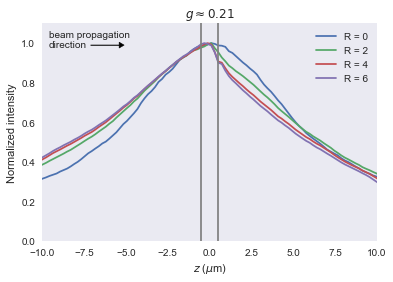

In [78]:
# pl.figure()
theo_beam = FocusedGaussianBeam(NA=0.4, n=1.33, trunc_coeff=4)
axint_theo = theo_beam.axial_intensity(axial_edges[0][1:])
axint_theo /= np.amax(axint_theo)
axint_theo[axint_theo==0] = 1
# axint_theo2 = intensity[:, intensity.shape[1]//2]
x = (axial_edges[scat_degree][1:] + axial_edges[scat_degree][:-1] ) / 2

pl.figure()
# pl.plot(x, axint_theo/np.amax(axint_theo), label=f'SDT')
# pl.plot(x, axint_theo2/np.amax(axint_theo2), label=f'SDT2')
for s in range(len(R)):
    x = (axial_edges[scat_degree][1:] + axial_edges[scat_degree][:-1] ) / 2
#     C, F, Q = linfoot(axial_intensities[s], axint_theo)
    ax_int_normed = axial_intensities[s] / np.amax(axial_intensities[s])
    ax_std_normed = axial_intensities_std[s] / np.amax(axial_intensities_std[s])
#     print(f'cross correlation: {cross_correlate_1d(ax_int_normed, axint_theo)}')
    pl.plot(x, ax_int_normed, label=f'R = {s*2}', alpha=1)
    # pl.fill_between(x, ax_int_normed-ax_std_normed, ax_int_normed+ax_std_normed, alpha=0.4)
    pl.xlim(-10, 10)
pl.xlabel(r'$z$ ($\mu$m)')
pl.ylabel('Normalized intensity')
# pl.title(f'R = {s*2}')
pl.axvline(x=-0.5, color='gray')
pl.axvline(x=0.5, color='gray')
pl.ylim(0, 1.1)
pl.legend(loc='best')
pl.title(r'$g \approx 0.21$')
arrow = -7.1, 0.99, 1.7, 0
pl.arrow(*arrow, shape='full', lw=0.5, length_includes_head=False, head_length=0.3, head_width=0.03, color='k')
pl.text(-9.6, 0.98, 'beam propagation \ndirection')
pl.savefig('isotropic-axialint.png', dpi=300)

In [ ]:
mean_free_path = []
path_length = []

for scat_degree in range(len(R)): 
    free_paths = FREE_PATHS[scat_degree]
    start_step = START_STEP[scat_degree]
    stop_step = STOP_STEP[scat_degree]
    mean_free_path.append([])
    path_length.append([])
    
    for trial in range(5):
        paths_in_medium = []
        ballistic = 0
        for photon in range(free_paths.shape[1]):
            start = start_step[trial, photon]
            stop = stop_step[trial, photon]
            if start==stop:
                ballistic += 1
            paths_in_medium.extend(free_paths[trial, photon, start:stop-2])
        mean_free_path[scat_degree].append(np.average(np.array(paths_in_medium)))
        path_length[scat_degree].append(np.sum(np.array(paths_in_medium)))
        print(f'number of ballistic photons: {ballistic}')

mean_free_path = np.array(mean_free_path)
path_length = np.array(path_length)
print()
print(mean_free_path)
print()
print(path_length)

#     print(f'R={scat_degree*2} \n Mean free path: {average_mfp} \n Average number of times scattered: {average_num_times_scattered} \n')

In [ ]:
ax = pl.subplot()
# ax.set_xscale("log", nonposx='clip')
# ax.set_yscale("log", nonposy='clip')
x = 1 / np.arange(2, 5, 2)
y = np.average(mean_free_path, axis=1)
yerr = np.std(mean_free_path, axis=1)
pl.errorbar(x, y, yerr=yerr, fmt='o')
# pl.plot(x, y, 'o')
pl.xlabel(r'mean free path from Degree of scattering ($d_s = h / R$)')
pl.ylabel('Calculated path ($d_s\'$)')
# pl.title('Calculated degree of scattering')
## do for higher degrees of scattering



In [ ]:
mean_free_path

In [ ]:
pl.plot(np.arange(2,9,2), np.average(mean_free_path[1:], axis=1), 'o')
pl.xlabel(r'Degree of scattering $R = h/d_s$')
pl.ylabel(r'Mean free path ($\mu s$)')